# Лабораторная работа №3
Выполнила Фонград Анастасия КИ21-16/1б

In [279]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, Lars, TweedieRegressor, BayesianRidge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd
import warnings
from math import log
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import mean_squared_error, r2_score
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
import numpy as np
import statsmodels.api as sm
from sklearn.feature_selection import SequentialFeatureSelector
from scipy.stats import t
from itertools import product
import seaborn as sns

In [280]:
train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

In [281]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         808 non-null    int64  
 1   Количество.комнат          808 non-null    int64  
 2   Студия                     808 non-null    int64  
 3   Общая.площадь              808 non-null    float64
 4   Этаж                       808 non-null    int64  
 5   Этажей.в.доме              808 non-null    int64  
 6   Парковка                   808 non-null    int64  
 7   Без.ремонта                808 non-null    int64  
 8   Дизайнерский               808 non-null    int64  
 9   Евроремонт                 808 non-null    int64  
 10  Косметический              808 non-null    int64  
 11  Балкон                     808 non-null    int64  
 12  Лоджия                     808 non-null    int64  
 13  Совмещенный.санузел        808 non-null    int64  

## Предварительная обработка данных

In [282]:
ids = test_data["id"]
train_data.drop("id", axis=1, inplace=True)
test_data.drop("id", axis=1, inplace=True)
answer = 'Цена'

In [283]:
train_data.describe()

,Количество.комнат,Студия,Общая.площадь,Этаж,Этажей.в.доме,Парковка,Без.ремонта,Дизайнерский,Евроремонт,Косметический,...,Одежда..1000,Супер3кет.1000,Кинотеатр.1000,Кафе.1000,АЗС.1000,Детский.сад.1000,Бар.1000,Банк.1000,Аптека.1000,Цена
count,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,...,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,8.080000e+02
mean,2.039604,0.040842,50.781176,4.894802,8.935644,0.142327,0.101485,0.024752,0.101485,0.772277,...,10.372525,4.674505,0.143564,7.788366,2.501238,13.263614,4.149752,6.754950,13.470297,2.699083e+06
std,0.996109,0.198046,19.827507,3.760826,4.754526,0.349601,0.302157,0.155466,0.302157,0.419622,...,15.397133,3.255991,0.378064,8.983450,1.636025,7.557860,5.955523,6.873569,8.068579,1.096460e+06
min,1.000000,0.000000,10.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.990000e+05
25%,1.000000,0.000000,37.650000,2.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,2.000000,2.000000,0.000000,3.000000,1.000000,8.000000,1.000000,2.000000,7.000000,1.950000e+06
50%,2.000000,0.000000,48.000000,4.000000,9.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,4.000000,4.000000,0.000000,6.000000,2.000000,13.000000,3.000000,5.000000,12.000000,2.550000e+06
75%,3.000000,0.000000,63.075000,6.000000,10.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,12.000000,7.000000,0.000000,9.000000,4.000000,18.000000,5.000000,10.000000,19.000000,3.310000e+06
max,5.000000,1.000000,120.000000,24.000000,26.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,86.000000,14.000000,2.000000,67.000000,8.000000,42.000000,52.000000,40.000000,40.000000,6.800000e+06


Можно увидеть, что категориальные признаки уже были закодированы. Для избежания ловушки фиктивных переменных были удалены некоторые колонки

In [284]:
train_data.drop("Без.ремонта", axis=1, inplace=True)
train_data.drop("Совмещенный.санузел", axis=1, inplace=True)
train_data.drop("Смешанные.стены", axis=1, inplace=True)
train_data.drop("Иные.перекрытия", axis=1, inplace=True)

Получим список всех числовых признаков. Числовыми будем считать признаки с более чем 5 уникальными значениями

In [285]:
numeric = []
categorical = []
for name in train_data.columns:
    if train_data[name].nunique() > 5:
        numeric.append(name)
    else:
        categorical.append(name)
numeric.remove(answer)
columns = numeric + categorical
print("Numeric features:", numeric)
print("Categorical features:", categorical)

Numeric features: ['Общая.площадь', 'Этаж', 'Этажей.в.доме', 'Год.постройки', 'Школа.1000', 'ВУЗ.1000', 'ТЦ.1000', 'Стоматология.1000', 'Почта.1000', 'Поликлиника.1000', 'Остановка.1000', 'Одежда..1000', 'Супер3кет.1000', 'Кафе.1000', 'АЗС.1000', 'Детский.сад.1000', 'Бар.1000', 'Банк.1000', 'Аптека.1000']
Categorical features: ['Количество.комнат', 'Студия', 'Парковка', 'Дизайнерский', 'Евроремонт', 'Косметический', 'Балкон', 'Лоджия', 'Раздельный.санузел', 'Лифт', 'Грузовой.лифт', 'Мусоропровод', 'Аварийный', 'Железобетонные.перекрытия', 'Смешанные.перекрытия', 'Деревянные.перекрытия', 'Панельные.стены', 'Блочные.стены', 'Деревянные.стены', 'Кирпичные.стены', 'Монолитные.стены', 'Парк.1000', 'Кинотеатр.1000']


Нормализуем числовые признаки

In [286]:
scaler = MinMaxScaler()
train_data[numeric] = scaler.fit_transform(train_data[numeric])
test_data[numeric] = scaler.fit_transform(test_data[numeric])
train_data.describe()

,Количество.комнат,Студия,Общая.площадь,Этаж,Этажей.в.доме,Парковка,Дизайнерский,Евроремонт,Косметический,Балкон,...,Одежда..1000,Супер3кет.1000,Кинотеатр.1000,Кафе.1000,АЗС.1000,Детский.сад.1000,Бар.1000,Банк.1000,Аптека.1000,Цена
count,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,...,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,8.080000e+02
mean,2.039604,0.040842,0.370738,0.169339,0.288985,0.142327,0.024752,0.101485,0.772277,0.632426,...,0.120611,0.333893,0.143564,0.116244,0.312655,0.315800,0.079803,0.168874,0.336757,2.699083e+06
std,0.996109,0.198046,0.180250,0.163514,0.198105,0.349601,0.155466,0.302157,0.419622,0.635417,...,0.179036,0.232571,0.378064,0.134081,0.204503,0.179949,0.114529,0.171839,0.201714,1.096460e+06
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.990000e+05
25%,1.000000,0.000000,0.251364,0.043478,0.125000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.023256,0.142857,0.000000,0.044776,0.125000,0.190476,0.019231,0.050000,0.175000,1.950000e+06
50%,2.000000,0.000000,0.345455,0.130435,0.291667,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.046512,0.285714,0.000000,0.089552,0.250000,0.309524,0.057692,0.125000,0.300000,2.550000e+06
75%,3.000000,0.000000,0.482500,0.217391,0.333333,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.139535,0.500000,0.000000,0.134328,0.500000,0.428571,0.096154,0.250000,0.475000,3.310000e+06
max,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,...,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.800000e+06


## Отбор информативных признаков
Построим матрицы корреляции признаков

<Axes: >

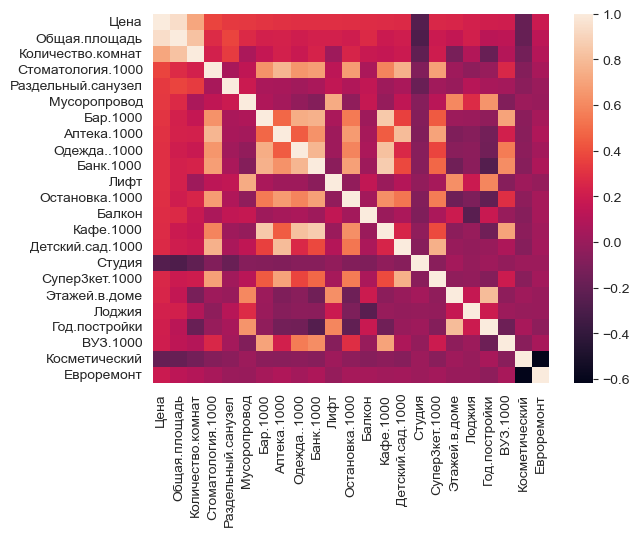

In [287]:
sorted_idx = train_data.corr()[answer].abs().sort_values(ascending=False).index[:23]
corr_matrix = train_data[sorted_idx].corr()
sns.heatmap(corr_matrix)

In [288]:
def show_correlation(names):
    corr_price_df = train_data.corr()[[answer]].transpose()[names]
    sb.heatmap(
    corr_price_df,
    annot=True,
    fmt='.1g',
    vmin=-1,
    vmax=1,
    )
    fig = plt.gcf()
    fig.set_size_inches(35, 5)

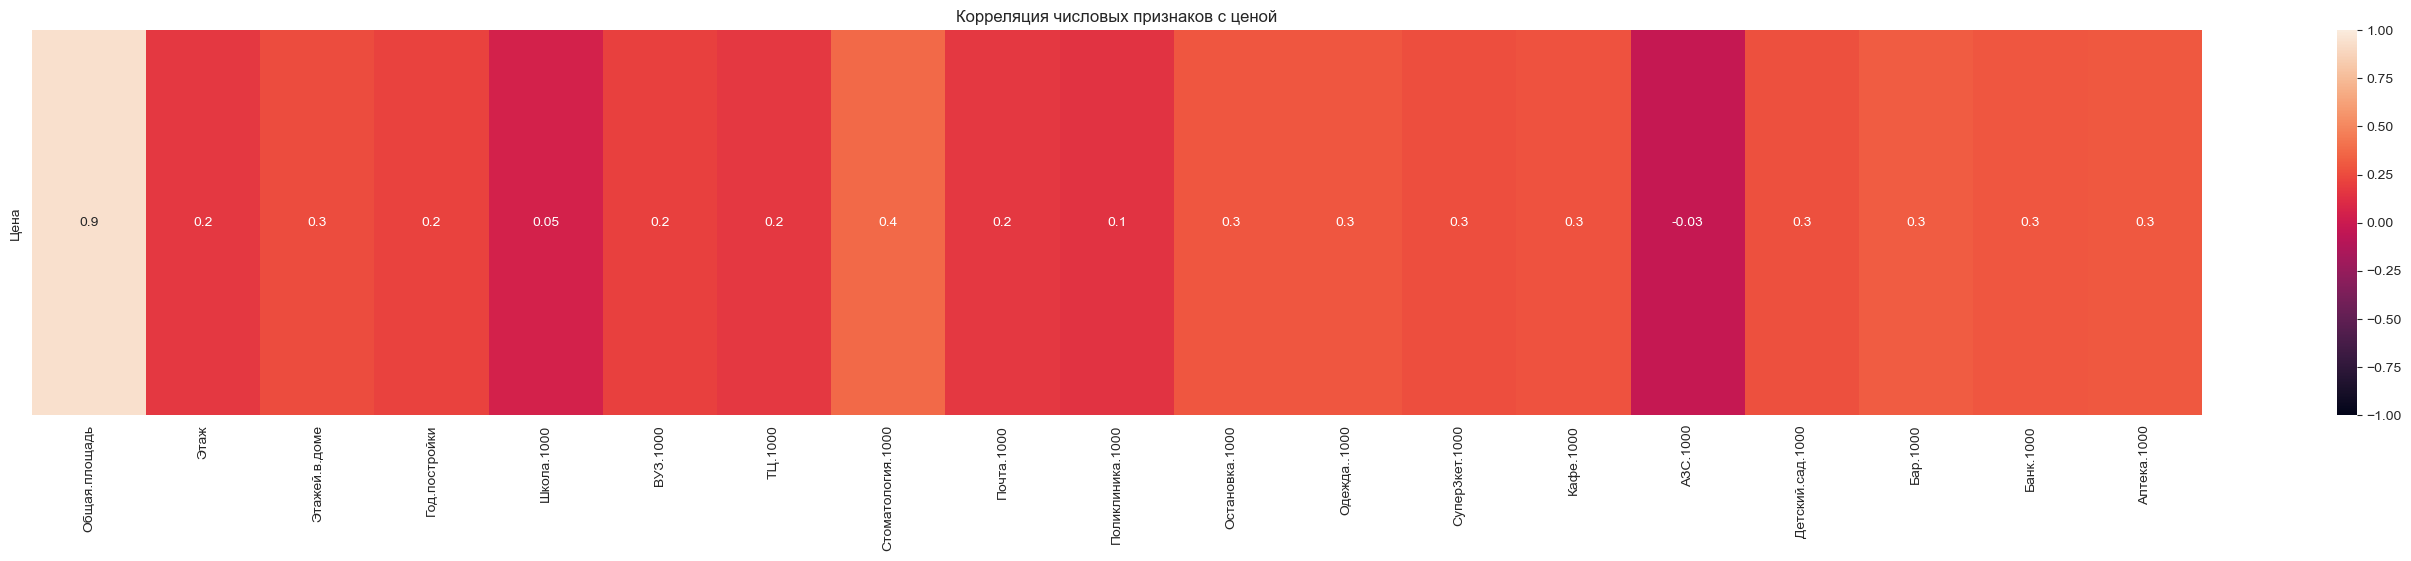

In [289]:
show_correlation(numeric)
plt.title("Корреляция числовых признаков с ценой")
plt.show()

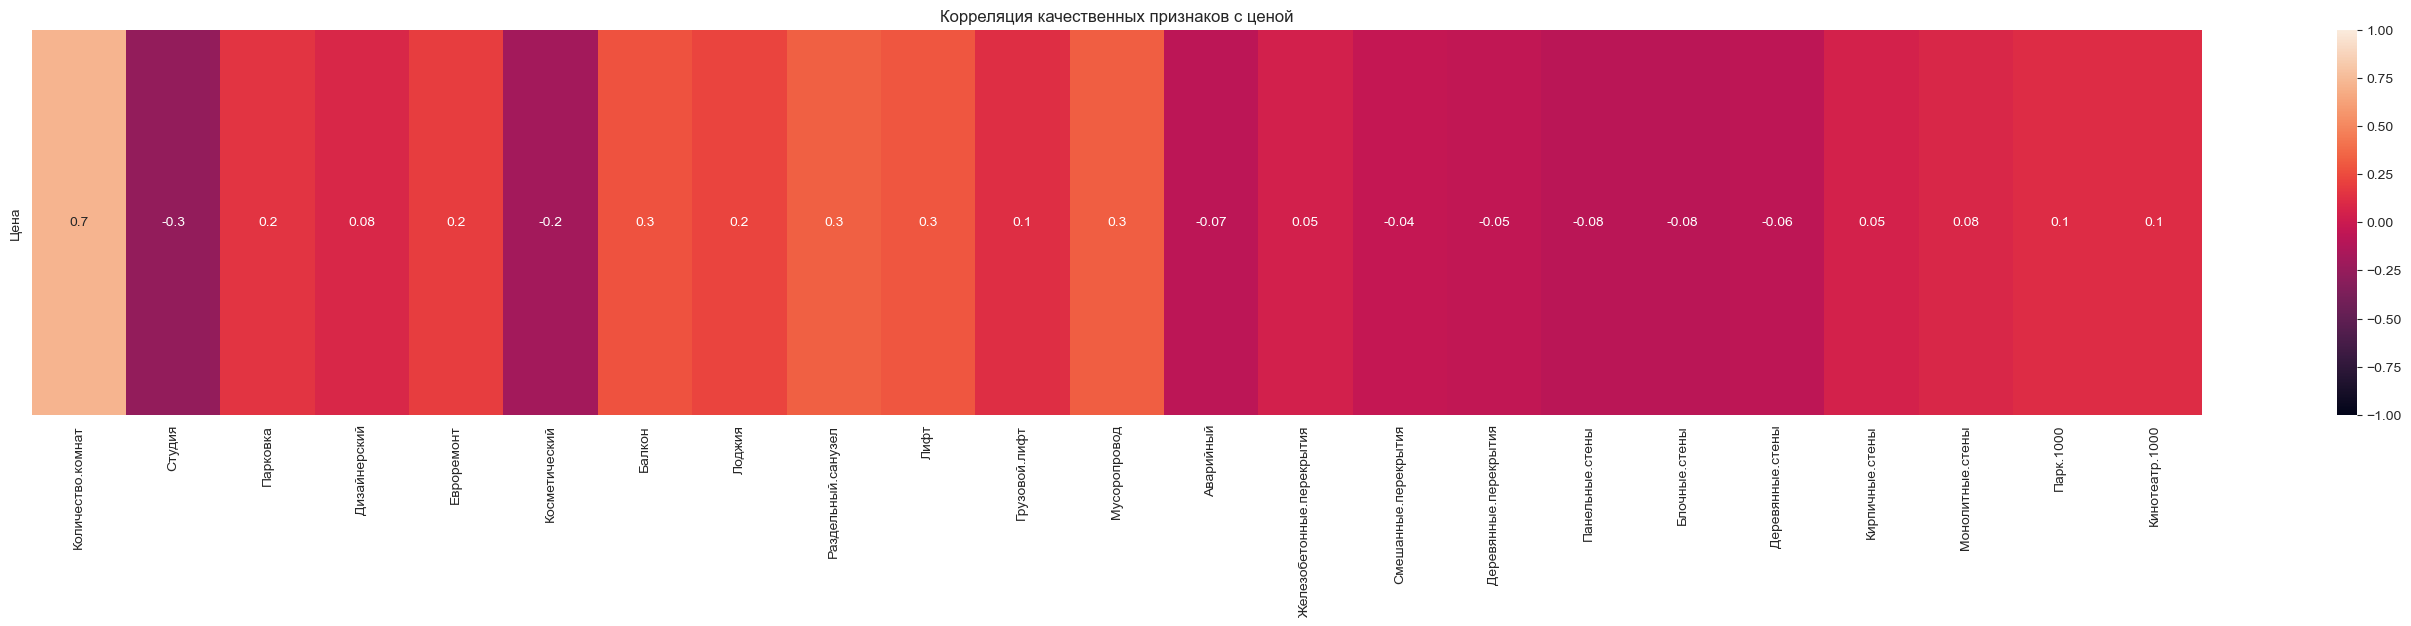

In [290]:
show_correlation(categorical)
plt.title("Корреляция качественных признаков с ценой")
plt.show()

Определим наиболее коррелирующие с ценой признаки

<Axes: >

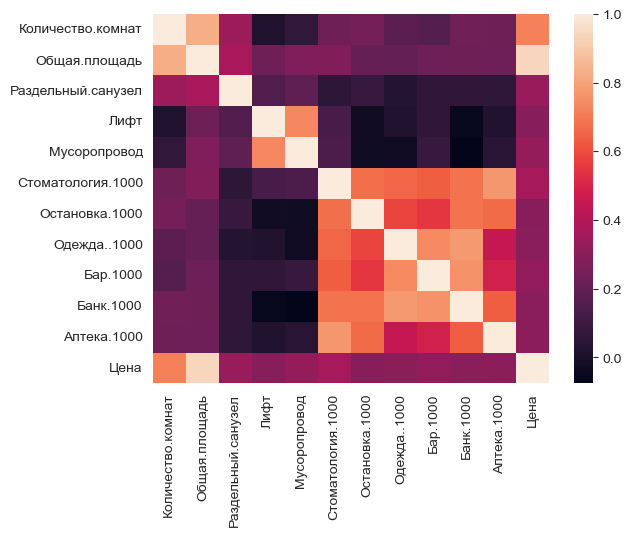

In [291]:
corr_matrix = train_data.corr()
threshold = 0.29
corr_price_matrix = train_data.corrwith(train_data[answer]).abs()
weak_corr_features = set(corr_matrix[corr_price_matrix <= threshold].index)
train_data.drop(weak_corr_features, axis=1, inplace=True)
sns.heatmap(train_data.corr())

Оставим только признаки, меньше всего коррелирующие друг с другом

<Axes: >

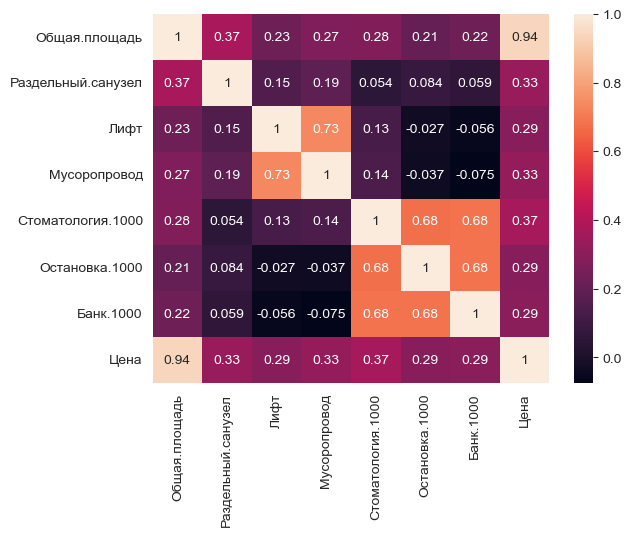

In [292]:
feature_select = train_data.drop(answer, axis=1)
corr_series = feature_select.corr().abs().stack().sort_values()
corr_series = corr_series[~corr_series.duplicated()]
threshold = 0.75
drops = set([feature2 for (feature1, feature2), corr in corr_series.items() if
             corr > threshold and corr != 1])
train_data.drop(drops, axis=1, inplace=True)
sns.heatmap(train_data.corr(), annot=True)

In [293]:
x = train_data.drop(columns=answer, axis=1)
y = train_data[answer]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7)

## Построение регрессионных моделей

In [294]:
def count_criteria(model, x_test, y_test):
    """
    Вычисляет все виды критериев для данной модели
    @:param model: модель линейной регрессии
    @:return: словарь значений критериев
    """
    y_pred = model.predict(x_test) if hasattr(model, "predict") else model.fit(x_test)[0]

    r_sq = r2_score(y_test, y_pred)

    n, m = x_test.shape
    adj_r_sq = 1 - (1 - r_sq) * (n - 1) / (n - m - 1)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    ll = -0.5 * (n * np.log(2 * np.pi) + n * np.log(
        np.sum(((y_test - y_pred) ** 2)) / n) + n)
    aic = 2 * m - 2 * ll
    bic = m * np.log(n) - 2 * ll

    res = pd.Series({
        "R^2": r_sq,
        "Adj R^2": adj_r_sq,
        "RMSE": rmse,
        "AIC": aic,
        "BIC": bic
    })
    return res

In [295]:
def get_stats_vals(fitted_model, x_test, y_test):
    """
    Вычисляет информацию обо всех коэффициентах модели
    @:param fitted_model: модель для вычисления
    @:return: все параметры коэффициента
    """

    n, p = x_test.shape

    mse = mean_squared_error(y_test, fitted_model.predict(x_test))
    std_errs = np.sqrt(np.diag(np.linalg.inv(np.dot(x_test.T, x_test))) * mse)
    coefs = fitted_model.coef_ if hasattr(fitted_model,
                                          "coef_") else fitted_model.params.values

    t_values = coefs / std_errs
    p_values = 2 * (1 - t.cdf(np.abs(t_values), df=n - p - 1))

    confidence_level = 0.95
    alpha = 1 - confidence_level
    t_critical = t.ppf(1 - alpha / 2, n - p - 1)
    conf_intervals = list(
        zip(coefs - t_critical * std_errs, coefs + t_critical * std_errs))
    is_hypothesis_rejected = np.abs(t_values) > t_critical

    data = pd.DataFrame(
        {
            'Name': x_test.columns,
            'Estimate': coefs,
            'Standard Error': std_errs,
            't-value': t_values,
            'p-value': p_values,
            '95% Confidence Interval': conf_intervals,
            'Is hypothesis rejected': is_hypothesis_rejected
        })
    return data

In [296]:
def sk_get_best(unfitted_model, params, x_train, y_train):
    """
    Определяет лучшую skilearn модель с параметрами
    @:param unfitted_model: необученная модель
    @:param params: параметры для обучения модели
    @:return: модель с лучшими параметрами
    """
    grid = GridSearchCV(unfitted_model, params, cv=5,
                        scoring="neg_mean_squared_error")
    grid.fit(x_train, y_train)
    return grid.best_estimator_


def sm_get_best(unfitted_model, params):
    """
    Определяет лучшую statmodel модель с параметрами
    @:param unfitted_model: необученная модель
    @:param params: параметры для обучения модели
    @:return: модель с лучшими параметрами
    """
    kfolder = KFold(n_splits=5, shuffle=True)
    param_keys = params.keys()
    fitted = []
    for param in product(*params.values()):
        param_dict = dict(zip(param_keys, param))
        for train_idx, test_idx in kfolder.split(x):
            x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            cur_model = unfitted_model(y_train, x_train, **param_dict)
            fitted_model = cur_model.fit()
            y_pred = fitted_model.predict(x_test)
            rmse = mean_squared_error(y_test, y_pred, squared=False)
            fitted.append({"model": fitted_model, "score": rmse})
    return min(fitted, key=lambda m_dict: m_dict["score"])["model"]

In [297]:
def show_model(model_name, model, stat_vals):
    print(model_name)
    print(model)
    print(stat_vals)

In [298]:
def build_sk_model(model_name, model_params, list_models):
    """
    :param model_name:
    :param model_params:
    :return:
    """
    model = model_params["model"]
    if model_params["selector"] == "SFS":
        selector = SequentialFeatureSelector(model)
        selector.fit(x_train, y_train)
        features = selector.get_support()
        x_train_sel, x_test_sel = x_train.loc[:, features], x_test.loc[:,
                                                                features]
    # Отдельно обрабатываем случай полиномиальной регрессии
    elif model_params["selector"] == "Poly":
        selector = PolynomialFeatures(degree=2)
        x_train_sel, x_test_sel = selector.fit_transform(
            x_train), selector.fit_transform(x_test)
    else:
        x_train_sel, x_test_sel = x_train, x_test
    fitted_model = sk_get_best(model, model_params["params"], x_train_sel, y_train)
    # Вычисляем критерии
    model_stats = count_criteria(fitted_model, x_test_sel, y_test)
    model_stats["Model name"] = model_name
    model_stats["Model"] = fitted_model
    list_models = list_models.append(model_stats, ignore_index=True)
    if model_params["selector"] not in ["Poly", "Not parametric"]:
        # Вычисляем информацию о коэффициентах
        coeff = get_stats_vals(fitted_model, x_test_sel, y_test)
    else:
        coeff = "Невозможно получить информацию о коэффициентах"
    show_model(model_name, model_stats, coeff)
    return list_models

In [299]:
def build_sm_model(cur_model_name, cur_model_params, list_models):
    fitted_model = sm_get_best(cur_model_params["model"], cur_model_params["params"])
    model_stats = count_criteria(fitted_model, x_test, y_test)
    model_stats["Model name"] = cur_model_name
    model_stats["Model"] = fitted_model
    list_models = list_models.append(model_stats, ignore_index=True)
    values = get_stats_vals(fitted_model, x_test, y_test)
    show_model(cur_model_name, model_stats, values)
    return list_models

Создадим фрейм для хранения характеристик модели

In [300]:
list_models = pd.DataFrame(
    {
        "Model name": [],
        "Model": [],
        "R^2": [],
        "Adj R^2": [],
        "RMSE": [],
        "AIC": [],
        "BIC": []
    }
)

### Линейная регрессия

In [301]:
linear_parameters = {
    "model": LinearRegression(),
    "params": {
        'fit_intercept': [True, False],
        'positive': [True, False],
    },
    "selector": "SFS",
    "kind": "sk"
}
list_models = build_sk_model(
    "Линейная регрессия",
    linear_parameters,
    list_models
)

Линейная регрессия
R^2                                  0.892566
Adj R^2                              0.891217
RMSE                            323082.386868
AIC                               6860.836169
BIC                               6871.315353
Model name                 Линейная регрессия
Model         LinearRegression(positive=True)
dtype: object
                Name      Estimate  Standard Error    t-value       p-value  \
0      Общая.площадь  5.390386e+06    94130.021915  57.265319  0.000000e+00   
1               Лифт  1.476439e+05    39289.425556   3.757854  2.154292e-04   
2  Стоматология.1000  6.987201e+05   124491.528686   5.612591  5.505546e-08   

                   95% Confidence Interval  Is hypothesis rejected  
0    (5204955.27957582, 5575816.158474435)                    True  
1  (70246.15178800371, 225041.72706350716)                    True  
2   (453479.3207132801, 943960.8568377082)                    True  


### Лассо регрессия

In [302]:
linear_parameters = {
    "model": Lasso(),
    "params": {
        'alpha': [0.01, 0.1, 1, 10, 100],
        'fit_intercept': [True, False],
        'positive': [True, False],
        'warm_start': [True, False],
        "selection": ["cyclic", "random"]
    },
    "selector": None,
    "kind": "sk"
}

list_models = build_sk_model(
    "Лассо регрессия",
    linear_parameters,
    list_models
)

Лассо регрессия
R^2                                                    0.891604
Adj R^2                                                0.888375
RMSE                                              324524.907977
AIC                                                 6871.001266
BIC                                                 6895.452696
Model name                                      Лассо регрессия
Model         Lasso(alpha=100, positive=True, selection='ran...
dtype: object
                 Name      Estimate  Standard Error    t-value   p-value  \
0       Общая.площадь  5.310209e+06   113027.102715  46.981732  0.000000   
1  Раздельный.санузел  0.000000e+00    44102.853419   0.000000  1.000000   
2                Лифт  9.617356e+04    65409.093871   1.470339  0.142807   
3        Мусоропровод  1.223005e+05    69946.529465   1.748486  0.081686   
4   Стоматология.1000  3.194837e+05   199245.510274   1.603468  0.110175   
5      Остановка.1000  3.786130e+05   149360.197667   2.534899  0.

### Гребневая регрессия

In [303]:
linear_parameters = {
    "model": Ridge(),
    "params": {
        'alpha': [0.01, 0.1, 1, 10, 100],
        'fit_intercept': [True, False],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
    },
    "selector": None,
}
list_models = build_sk_model(
    "Гребневая регрессия",
    linear_parameters,
    list_models
)

Гребневая регрессия
R^2                                  0.891823
Adj R^2                                0.8886
RMSE                            324197.883283
AIC                               6870.511276
BIC                               6894.962706
Model name                Гребневая регрессия
Model         Ridge(alpha=0.01, solver='sag')
dtype: object
                 Name      Estimate  Standard Error    t-value   p-value  \
0       Общая.площадь  5.362420e+06   112913.204974  47.491524  0.000000   
1  Раздельный.санузел -4.766912e+04    44058.410846  -1.081953  0.280383   
2                Лифт  9.699234e+04    65343.180936   1.484353  0.139055   
3        Мусоропровод  1.261332e+05    69876.044144   1.805099  0.072339   
4   Стоматология.1000  2.977931e+05   199044.729993   1.496111  0.135966   
5      Остановка.1000  4.003643e+05   149209.686961   2.683232  0.007810   
6           Банк.1000  1.648238e+05   220603.230608   0.747150  0.455720   

                     95% Confidence

### Elastic-Net

In [304]:
linear_parameters = {
    "model": ElasticNet(),
    "params": {
        'alpha': [0.01, 0.1, 1, 10, 100],
        'l1_ratio': [0.2, 0.5, 0.8],
        'fit_intercept': [True, False],
    },
    "selector": None,
}
list_models = build_sk_model(
    "Elastic-Net",
    linear_parameters,
    list_models
)

Elastic-Net
R^2                                       0.885632
Adj R^2                                   0.882226
RMSE                                 333344.554048
AIC                                    6884.033046
BIC                                    6908.484476
Model name                             Elastic-Net
Model         ElasticNet(alpha=0.01, l1_ratio=0.8)
dtype: object
                 Name      Estimate  Standard Error    t-value   p-value  \
0       Общая.площадь  4.976923e+06   116098.851656  42.867980  0.000000   
1  Раздельный.санузел  2.681255e+03    45301.441104   0.059187  0.952853   
2                Лифт  1.037047e+05    67186.723395   1.543530  0.124048   
3        Мусоропровод  1.502954e+05    71847.473333   2.091868  0.037524   
4   Стоматология.1000  3.383000e+05   204660.425551   1.652982  0.099670   
5      Остановка.1000  3.932454e+05   153419.374784   2.563206  0.010995   
6           Банк.1000  2.220886e+05   226827.161189   0.979109  0.328533   

        

### Метод наименьших углов

In [305]:
linear_parameters = {
    "model": Lars(),
    "params": {
        'n_nonzero_coefs': [100, 500, 1000],
        'fit_intercept': [True, False],
        'normalize': [True, False],
    },
    "selector": "SFS",
}
list_models = build_sk_model(
    "Метод наименьших углов",
    linear_parameters,
    list_models
)

Метод наименьших углов
R^2                                             0.892566
Adj R^2                                         0.891217
RMSE                                       323082.386868
AIC                                          6860.836169
BIC                                          6871.315353
Model name                        Метод наименьших углов
Model         Lars(n_nonzero_coefs=100, normalize=False)
dtype: object
                Name      Estimate  Standard Error    t-value       p-value  \
0      Общая.площадь  5.390386e+06    94130.021915  57.265319  0.000000e+00   
1               Лифт  1.476439e+05    39289.425556   3.757854  2.154292e-04   
2  Стоматология.1000  6.987201e+05   124491.528686   5.612591  5.505546e-08   

                   95% Confidence Interval  Is hypothesis rejected  
0    (5204955.279575805, 5575816.15847442)                    True  
1  (70246.15178800358, 225041.72706350707)                    True  
2   (453479.3207132807, 943960.856837708

### Байесовская регрессия

In [306]:
linear_parameters = {
    "model": BayesianRidge(),
    "params": {
        'n_iter': [200, 400, 600],
        'tol': [1e-4, 1e-5, 1e-6],
        'alpha_1': [1e-6, 1e-7, 1e-8],
        'alpha_2': [1e-6, 1e-7, 1e-8],
        'lambda_1': [1e-6, 1e-7, 1e-8],
        'lambda_2': [1e-6, 1e-7, 1e-8],
    },
    "selector": None,
}
list_models = build_sk_model(
    "Байесовская регрессия",
    linear_parameters,
    list_models
)

Байесовская регрессия
R^2                                                    0.891779
Adj R^2                                                0.888556
RMSE                                              324262.677014
AIC                                                 6870.608397
BIC                                                 6895.059827
Model name                                Байесовская регрессия
Model         BayesianRidge(alpha_1=1e-08, lambda_1=1e-07, n...
dtype: object
                 Name      Estimate  Standard Error    t-value   p-value  \
0       Общая.площадь  5.354929e+06   112935.771648  47.415700  0.000000   
1  Раздельный.санузел -4.670903e+04    44067.216297  -1.059950  0.290256   
2                Лифт  9.733434e+04    65356.240332   1.489289  0.137752   
3        Мусоропровод  1.263011e+05    69890.009472   1.807141  0.072019   
4   Стоматология.1000  2.986740e+05   199084.510792   1.500237  0.134895   
5      Остановка.1000  4.003056e+05   149239.507798   2.6823

### Обобщённый МНК
Обобщенная линейная регрессия (обобщенный МНК) - это метод, который расширяет линейную регрессию на случаи, когда зависимая переменная имеет не нормальное распределение или связана с независимыми переменными нелинейно.

In [307]:
linear_parameters = {
    "model": sm.GLS,
    "params": {
        'sigma': [0.1, 0.5, 1.0],
        'hasconst': [True, False],
        'cov_type': ['nonrobust', 'HC0', 'HC1', 'HC2', 'HC3', 'HAC'],
        'kernel': ['bartlett', 'uniform', 'parzen', 'quadratic', 'triangular', 'cosine'],
        'dew': [False, True]
    },
}
list_models = build_sm_model(
    "Обобщённая линейная регрессия",
    linear_parameters,
    list_models
)

Обобщённая линейная регрессия
R^2                                                    0.874055
Adj R^2                                                0.870304
RMSE                                              349809.641753
AIC                                                 6907.464308
BIC                                                 6931.915738
Model name                        Обобщённая линейная регрессия
Model         <statsmodels.regression.linear_model.Regressio...
dtype: object
                 Name      Estimate  Standard Error    t-value       p-value  \
0       Общая.площадь  5.790202e+06   121833.391944  47.525571  0.000000e+00   
1  Раздельный.санузел -1.479059e+04    47539.042384  -0.311125  7.559814e-01   
2                Лифт  1.197154e+05    70505.317564   1.697963  9.083839e-02   
3        Мусоропровод  1.573071e+05    75396.278722   2.086404  3.802059e-02   
4   Стоматология.1000  2.046988e+05   214769.340832   0.953110  3.415136e-01   
5      Остановка.1000  8.936

### Взвешенный МНК
Дает разные веса наблюдениям в зависимости от их точности или важности. Минимизирует сумму взвешенных квадратов разности между прогнозируемыми и наблюдаемыми значениями.

In [308]:
linear_parameters = {
    "model": sm.WLS,
    "params": {
        'missing': ['none', 'drop', 'raise'],
        'hasconst': [True, False],
        'cov_type': ['nonrobust', 'HC0', 'HC1', 'HC2', 'HC3', 'HAC'],
        'kernel': ['bartlett', 'uniform', 'parzen', 'quadratic', 'triangular', 'cosine']
    },
}
list_models = build_sm_model(
    "Взвешенный МНК",
    linear_parameters,
    list_models
)

Взвешенный МНК
R^2                                                    0.874595
Adj R^2                                                 0.87086
RMSE                                              349059.411174
AIC                                                 6906.420873
BIC                                                 6930.872303
Model name                                       Взвешенный МНК
Model         <statsmodels.regression.linear_model.Regressio...
dtype: object
                 Name      Estimate  Standard Error    t-value       p-value  \
0       Общая.площадь  5.816894e+06   121572.098013  47.847277  0.000000e+00   
1  Раздельный.санузел -4.828766e+04    47437.086237  -1.017931  3.097577e-01   
2                Лифт  1.439815e+05    70354.106051   2.046525  4.181760e-02   
3        Мусоропровод  1.406105e+05    75234.577651   1.868961  6.287227e-02   
4   Стоматология.1000  1.935668e+05   214308.728808   0.903215  3.673368e-01   
5      Остановка.1000  8.875082e+05   16065

### Полиномиальная регрессия
Зависимость между независимой переменной x и зависимой переменной y моделируется как полином n-й степени в x. Полиномиальная регрессия может быть использована для аппроксимации нелинейных данных и изучения сложных и изогнутых зависимостей.

In [309]:
linear_parameters = {
    "model": LinearRegression(),
    "params": {
        'fit_intercept': [True, False],
        'positive': [True, False],
    },
    "selector": "Poly",
}
# model = Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression(fit_intercept=False))])
list_models = build_sk_model(
    "Полиномиальная регрессия",
    linear_parameters,
    list_models
)

Полиномиальная регрессия
R^2                                                    0.893461
Adj R^2                                                0.874843
RMSE                                              321733.176132
AIC                                                 6924.802355
BIC                                                 7050.552567
Model name                             Полиномиальная регрессия
Model         LinearRegression(fit_intercept=False, positive...
dtype: object
Невозможно получить информацию о коэффициентах


### Непараметрическая регрессия
Регрессия ближайших соседей

In [310]:
linear_parameters = {
    "model": KNeighborsRegressor(),
    "params": {
        "n_neighbors": [2, 3, 4, 5, 6],
    },
    "selector": "Not parametric"
}
list_models = build_sk_model(
    "Непараметрическая регрессия",
    linear_parameters,
    list_models
)

Непараметрическая регрессия
R^2                                     0.716178
Adj R^2                                 0.707724
RMSE                               525127.916143
AIC                                  7104.903148
BIC                                  7129.354578
Model name           Непараметрическая регрессия
Model         KNeighborsRegressor(n_neighbors=4)
dtype: object
Невозможно получить информацию о коэффициентах


Ядерная регрессия

In [323]:
def count_criteria_kernel(model, x_test, y_test):
    """
    Вычисляет все виды критериев для ядерной регрессии
    @:param model: модель линейной регрессии
    @:return: словарь значений критериев
    """
    y_pred = model.predict(x_test) if hasattr(model, "predict") else model.fit(x_test)[0]

    r_sq = r2_score(y_test, y_pred)

    n, m = x_test.shape
    adj_r_sq = 1 - (1 - r_sq) * (n - 1) / (n - m - 1)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    ll = -0.5 * (n * np.log(2 * np.pi) + n * np.log(
        np.sum(((y_test - y_pred) ** 2)) / n) + n)
    aic = 2 * m - 2 * ll
    bic = m * np.log(n) - 2 * ll

    res = {
        "R^2": r_sq,
        "Adj R^2": adj_r_sq,
        "RMSE": rmse,
        "AIC": aic,
        "BIC": bic
    }
    return res

In [326]:
kernel_model = sm.nonparametric.KernelReg(y_train, x_train, var_type="".join(
    ["c" if len(x_train[col].value_counts()) > 2 else "u" for col in
     x_train.columns]))

In [336]:
kernel_stats = count_criteria(kernel_model, x_test, y_test)
kernel_stats["Model name"] = "Ядерная регрессия"
kernel_stats["Model"] = kernel_model
list_models = list_models.append(kernel_stats, ignore_index=True)
show_model("Ядерная регрессия", kernel_stats, "Невозможно получить информацию о коэффициентах")

Ядерная регрессия
R^2                                                    0.897392
Adj R^2                                                0.894335
RMSE                                              315742.488817
AIC                                                 6857.667701
BIC                                                 6882.119131
Model name                                    Ядерная регрессия
Model         KernelReg instance\nNumber of variables: k_var...
dtype: object
Невозможно получить информацию о коэффициентах


## Сравнение регрессионных моделей

In [333]:
models = list_models["Model"]
list_models.drop("Model", axis=1, inplace=True)
print(list_models)

                       Model name       R^2   Adj R^2           RMSE  \
0              Линейная регрессия  0.892566  0.891217  323082.386868   
1                 Лассо регрессия  0.891604  0.888375  324524.907977   
2             Гребневая регрессия  0.891823  0.888600  324197.883283   
3                     Elastic-Net  0.885632  0.882226  333344.554048   
4          Метод наименьших углов  0.892566  0.891217  323082.386868   
5           Байесовская регрессия  0.891779  0.888556  324262.677014   
6   Обобщённая линейная регрессия  0.874055  0.870304  349809.641753   
7                  Взвешенный МНК  0.874595  0.870860  349059.411174   
8        Полиномиальная регрессия  0.893461  0.874843  321733.176132   
9     Непараметрическая регрессия  0.716178  0.707724  525127.916143   
10              Ядерная регрессия  0.897392  0.894335  315742.488817   

            AIC          BIC  
0   6860.836169  6871.315353  
1   6871.001266  6895.452696  
2   6870.511276  6894.962706  
3   6884.03

In [334]:
def compare_models():
    """
    Выводит графики для сравнения моделей
    :return:
    """
    ylims = {
        "R^2": [min(list_models["R^2"]) - 0.01, max(list_models["R^2"]) + 0.01],
        "Adj R^2": [min(list_models["Adj R^2"]) - 0.01, max(list_models["Adj R^2"]) + 0.01],
        "RMSE": [min(list_models["RMSE"]) - 1000, max(list_models["RMSE"]) + 1000],
        "AIC": [min(list_models["AIC"]) - 10, max(list_models["AIC"]) + 10],
        "BIC": [min(list_models["BIC"]) - 10, max(list_models["BIC"]) + 10],
    }

    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 25))
    fig.subplots_adjust(hspace=0.4)

    for ax, comb in zip(axs.flatten(),
                        product(["Model name"], list_models.columns.tolist()[1:])):
        model_names, cur_stat = comb
        to_plot = list_models[list(comb)]
        title = cur_stat
        ax.set_ylim(ylims[title])
        ax.set_title(title)

        ax.bar(list_models[model_names], list_models[cur_stat])
        ax.set_xticklabels(list(to_plot[model_names]), rotation=90)

        for i, val in enumerate(to_plot[cur_stat]):
            ax.text(i, val, str(round(val, 5 if val < 1 else None)), ha='center',
                    va='bottom')

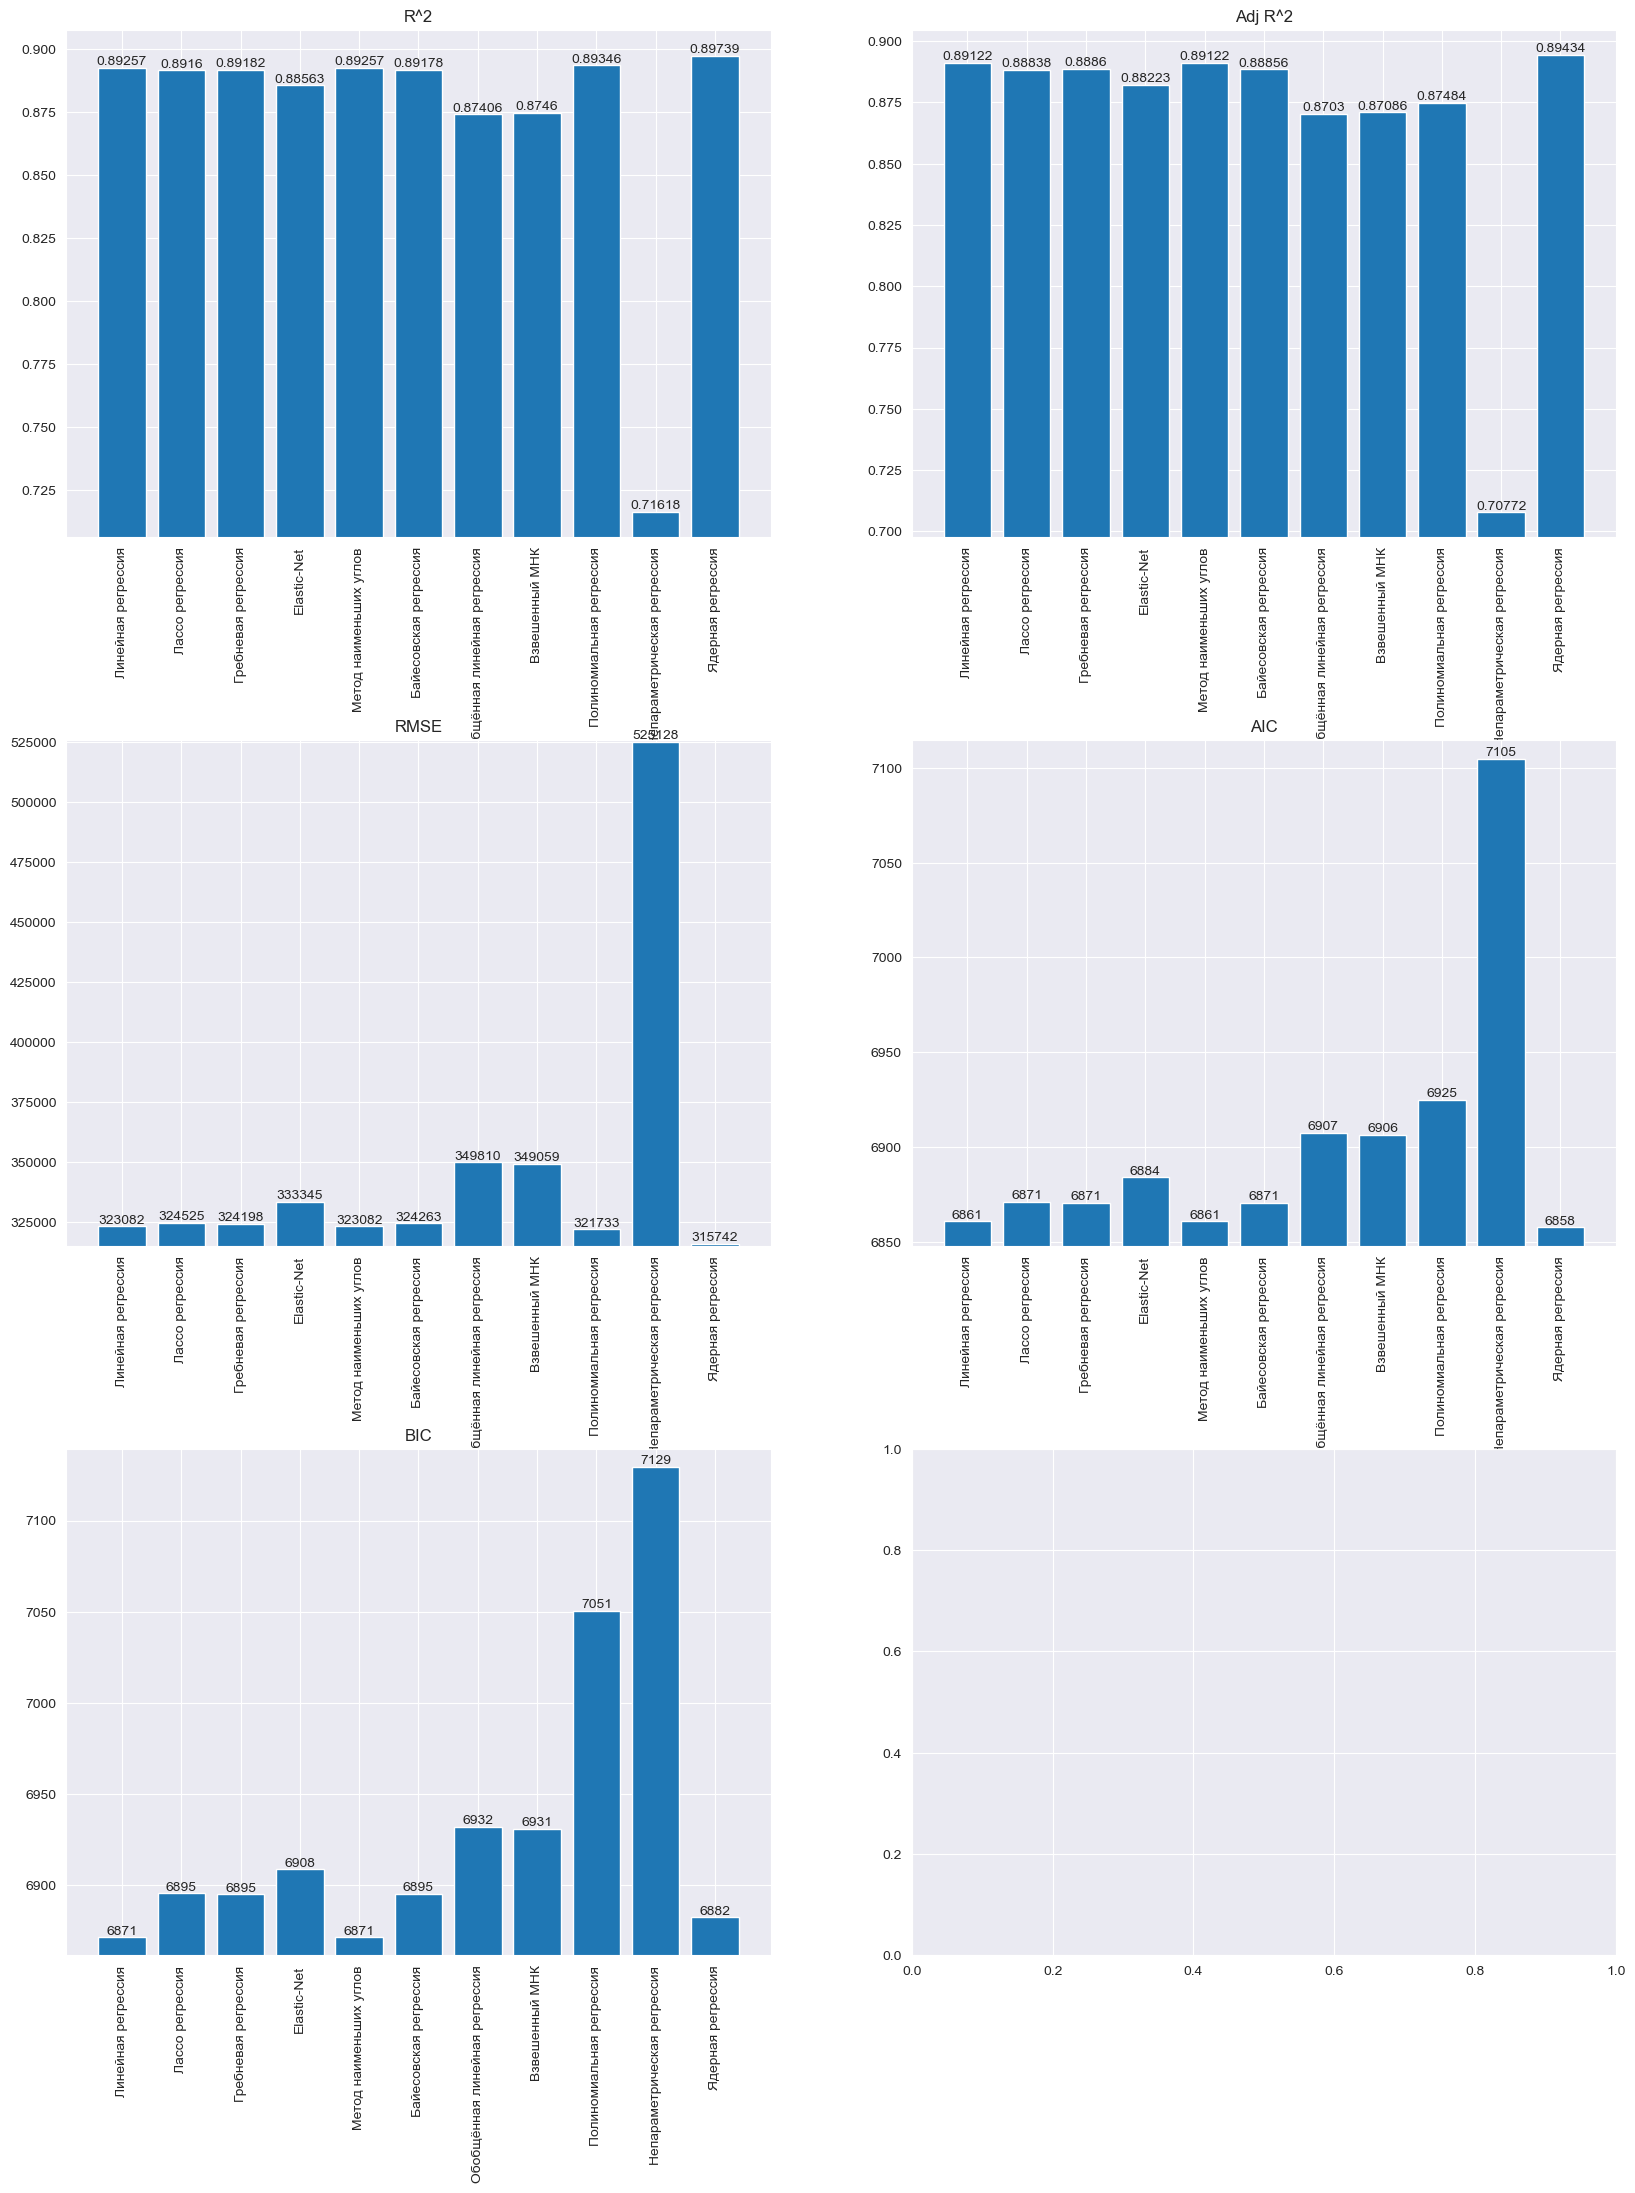

In [335]:
compare_models()

In [341]:
print("Лучшие модели")
print(list_models[list_models["Adj R^2"] == list_models["Adj R^2"].max()]["Model name"])

Лучшие модели
10    Ядерная регрессия
11    Ядерная регрессия
Name: Model name, dtype: object


In [316]:
def create_submission(id_col, y_pred) -> pd.DataFrame:
    """Создание итоговой выборки."""
    submission = pd.DataFrame({
        "id": id_col,
        "Цена": y_pred,
    })
    return submission

In [ ]:
model = models[-1]
y_test_predicted = model.predict(train_data)
sub = create_submission(
    ids,
    list(item for item in y_test_predicted.tolist()),
)
sub.to_csv("../data/sub.csv", index=False)